By Moshe Haziza for AiDock -- 12/05/2022

#Libraries and Data Import

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_auc_score

import scipy.cluster.hierarchy as sch

In [2]:
# Loading the data and showing the first 5 rows
hotels = pd.read_csv('hotels_data.csv')
hotels.head()

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars
0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3
1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3
2,1,7/17/2015 0:00,8/13/2015 0:00,5,4370,4240,1,3,The Peninsula New York,5
3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4
4,1,7/17/2015 0:00,8/12/2015 0:00,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4


In [3]:
# Changing the date columns to dates
hotels['Snapshot Date'] = pd.to_datetime(hotels['Snapshot Date'])
hotels['Checkin Date'] = pd.to_datetime(hotels['Checkin Date'])
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187848 entries, 0 to 187847
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Snapshot ID      187848 non-null  int64         
 1   Snapshot Date    187848 non-null  datetime64[ns]
 2   Checkin Date     187848 non-null  datetime64[ns]
 3   Days             187848 non-null  int64         
 4   Original Price   187848 non-null  int64         
 5   Discount Price   187848 non-null  int64         
 6   Discount Code    187848 non-null  int64         
 7   Available Rooms  187848 non-null  int64         
 8   Hotel Name       187848 non-null  object        
 9   Hotel Stars      187848 non-null  int64         
dtypes: datetime64[ns](2), int64(7), object(1)
memory usage: 14.3+ MB


In [4]:
hotels[hotels.columns].nunique()

Snapshot ID         160
Snapshot Date       151
Checkin Date        202
Days                  1
Original Price     3065
Discount Price     3899
Discount Code         4
Available Rooms     321
Hotel Name          554
Hotel Stars           6
dtype: int64

# Question 1

In [5]:
# Day difference between the snapshot date and the checkin date
hotels['DayDiff'] = (hotels['Checkin Date'] - hotels['Snapshot Date']).dt.days
# Weekday as Monday=0, Sunday=6
hotels['WeekDay'] = hotels['Checkin Date'].dt.dayofweek
# Discount Value
hotels['DiscountDiff'] = hotels['Original Price'] - hotels['Discount Price']
# Discount percentage
hotels['DiscountPerc'] = hotels['DiscountDiff'] / hotels['Original Price']
hotels.head()

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,1,2015-07-17,2015-08-12,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,2,138,0.117148
1,1,2015-07-17,2015-08-19,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,2,131,0.117700
2,1,2015-07-17,2015-08-13,5,4370,4240,1,3,The Peninsula New York,5,27,3,130,0.029748
3,1,2015-07-17,2015-07-26,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,6,72,0.041403
4,1,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,2,67,0.038528


In [6]:
hotels.describe()

,Snapshot ID,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
count,187848.000000,187848.0,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000
mean,351.643451,5.0,1825.742143,1673.172283,2.434186,14.588561,3.905823,17.465685,2.917763,152.569860,0.088777
std,1007.348927,0.0,1042.355712,983.618013,1.005191,41.575482,0.846496,10.040225,1.840536,143.316985,0.060302
min,1.000000,5.0,289.000000,260.000000,1.000000,-1.000000,0.000000,1.000000,0.000000,15.000000,0.005814
25%,150.000000,5.0,1160.000000,1035.000000,2.000000,-1.000000,3.000000,9.000000,2.000000,70.000000,0.048450
50%,439.000000,5.0,1599.000000,1475.000000,2.000000,-1.000000,4.000000,18.000000,3.000000,103.000000,0.070562
75%,506.000000,5.0,2160.000000,1963.250000,3.000000,8.000000,4.000000,26.000000,4.000000,180.000000,0.109339
max,417419.000000,5.0,29975.000000,28675.000000,4.000000,431.000000,5.000000,34.000000,6.000000,3760.000000,0.684258


In [7]:
hotels.to_csv("Hotels_data_Changed.csv")

#Question 2: Classification

In [8]:
hotels_changed = pd.read_csv('Hotels_data_Changed.csv')
hotels_changed.head()

,Unnamed: 0,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,0,1,2015-07-17,2015-08-12,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,2,138,0.117148
1,1,1,2015-07-17,2015-08-19,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,2,131,0.117700
2,2,1,2015-07-17,2015-08-13,5,4370,4240,1,3,The Peninsula New York,5,27,3,130,0.029748
3,3,1,2015-07-17,2015-07-26,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,6,72,0.041403
4,4,1,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,2,67,0.038528


In [9]:
#selected_columns = hotels_changed[['Snapshot Date', 'Checkin Date' , 'DayDiff' , 'Hotel Name', 'WeekDay','Discount Code']]
selected_columns = hotels_changed[['Snapshot Date', 'Checkin Date' , 'DayDiff' , 'WeekDay','Discount Code']]
hotels_changed_2 = selected_columns.copy()

hotels_changed_2['Snapshot Date'] = pd.to_datetime(hotels_changed_2['Snapshot Date'])
hotels_changed_2['Checkin Date'] = pd.to_datetime(hotels_changed_2['Checkin Date'])

hotels_changed_2.head()

,Snapshot Date,Checkin Date,DayDiff,WeekDay,Discount Code
0,2015-07-17,2015-08-12,26,2,1
1,2015-07-17,2015-08-19,33,2,1
2,2015-07-17,2015-08-13,27,3,1
3,2015-07-17,2015-07-26,9,6,1
4,2015-07-17,2015-08-12,26,2,1


In [10]:
# Specia normalization for dates - days from 1st day
hotels_changed_2['Snapshot Date'] = (hotels_changed_2['Snapshot Date'] - hotels_changed_2['Snapshot Date'].min()).dt.days
hotels_changed_2['Checkin Date'] = (hotels_changed_2['Checkin Date'] - hotels_changed_2['Checkin Date'].min()).dt.days
hotels_changed_2.head()

,Snapshot Date,Checkin Date,DayDiff,WeekDay,Discount Code
0,0,25,26,2,1
1,0,32,33,2,1
2,0,26,27,3,1
3,0,8,9,6,1
4,0,25,26,2,1


In [11]:
#Changing the dependant variable to binary as discount code of 1 seems to give the best discount
hotels_changed_2.loc[hotels_changed_2['Discount Code'] != 1 , 'Discount Code'] = 0
hotels_changed_2.head()

,Snapshot Date,Checkin Date,DayDiff,WeekDay,Discount Code
0,0,25,26,2,1
1,0,32,33,2,1
2,0,26,27,3,1
3,0,8,9,6,1
4,0,25,26,2,1


In [12]:
hotels_changed_2.describe()

,Snapshot Date,Checkin Date,DayDiff,WeekDay,Discount Code
count,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000
mean,79.980745,96.446430,17.465685,2.917763,0.209057
std,46.982385,47.588446,10.040225,1.840536,0.406636
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,39.000000,55.000000,9.000000,2.000000,0.000000
50%,81.000000,98.000000,18.000000,3.000000,0.000000
75%,115.000000,131.000000,26.000000,4.000000,0.000000
max,168.000000,201.000000,34.000000,6.000000,1.000000


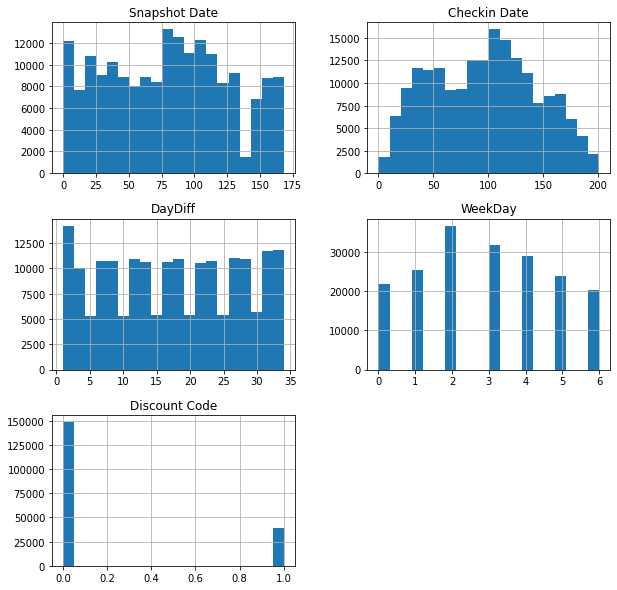

In [13]:
hotels_changed_2[hotels_changed_2.columns].hist(figsize=(10,10) ,bins = 20);

In [14]:
hotels_changed_2[hotels_changed_2.columns].nunique()

Snapshot Date    151
Checkin Date     202
DayDiff           34
WeekDay            7
Discount Code      2
dtype: int64

In [15]:
#Correlations with  Discount Code
hotels_changed_2[hotels_changed_2.columns[:]].corr()['Discount Code'][:].sort_values(ascending = False)

Discount Code    1.000000
WeekDay          0.099883
Snapshot Date   -0.007365
Checkin Date    -0.011232
DayDiff         -0.018774
Name: Discount Code, dtype: float64

In [16]:
X = hotels_changed_2.iloc[:, :-1].values
y = hotels_changed_2.iloc[:, -1].values

In [17]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [4])], remainder='passthrough')
# X = np.array(ct.fit_transform(X))

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [19]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

## Decision Tree

In [38]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('FP: ', cm[0][1])
print('FN: ', cm[1][0])
print('ROC: ', roc_auc_score(y_test, y_pred))

[[37044   186]
 [ 9652    80]]
FP:  186
FN:  9652
Roc:  0.5016121665800587


Feature: 0, Score: 0.25302
Feature: 1, Score: 0.18620
Feature: 2, Score: 0.21635
Feature: 3, Score: 0.34443


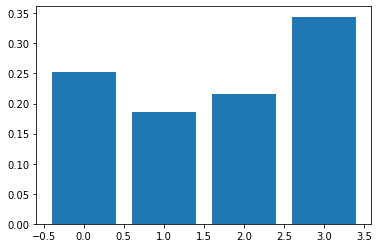

In [21]:
#Feature Importance
importance = tree.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

The results are not good and can be improved by more preporcessing (i.e.: transformations, SMOTE)

## Naive Bayes

In [39]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('FP: ', cm[0][1])
print('FN: ', cm[1][0])
print('ROC: ', roc_auc_score(y_test, y_pred))

[[37230     0]
 [ 9732     0]]
FP:  0
FN:  9732
ROC:  0.5


Naive bayes predicts all results as 0. The data being unbalanced, the ROC can be seen as a good result but it is not. It can be detected by other performance tools as F1.

# Question 3: Clustering

In [23]:
hotels_changed = pd.read_csv('Hotels_data_Changed.csv')
hotels_changed.head()

,Unnamed: 0,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,0,1,2015-07-17,2015-08-12,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,2,138,0.117148
1,1,1,2015-07-17,2015-08-19,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,2,131,0.117700
2,2,1,2015-07-17,2015-08-13,5,4370,4240,1,3,The Peninsula New York,5,27,3,130,0.029748
3,3,1,2015-07-17,2015-07-26,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,6,72,0.041403
4,4,1,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,2,67,0.038528


In [24]:
#3.6
# top 150 hotels
top_hotels = hotels_changed['Hotel Name'].value_counts()[0:150]
#top 40 checkin dates
top_checkin = hotels_changed['Checkin Date'].value_counts()[0:40]

hotels_changed_3 = hotels_changed[hotels_changed['Hotel Name'].isin(top_hotels.index)]
hotels_changed_3 = hotels_changed_3[hotels_changed_3['Checkin Date'].isin(top_checkin.index)]
hotels_changed_3.head(5)

,Unnamed: 0,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
4,4,1,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,2,67,0.038528
7,7,1,2015-07-17,2015-08-12,5,1256,1183,1,5,Grand Hyatt New York,4,26,2,73,0.058121
29,29,1,2015-07-17,2015-08-12,5,3763,3378,1,39,Park Hyatt New York,5,26,2,385,0.102312
58,58,1,2015-07-17,2015-08-19,5,747,671,1,-1,Hilton Garden Inn New York Long Island City,3,33,2,76,0.101740
62,62,1,2015-07-17,2015-08-12,5,750,690,1,-1,Hilton Newark Airport,4,26,2,60,0.080000


In [25]:
#Creating empty DataFrame to fill afterward, multi-index columns: discount code and checkin date, rows: hotlels' names
my_array = []
for discount in range(1,5):
  for index in top_checkin.index:
    my_array.append((discount,index))

cols = pd.MultiIndex.from_tuples(my_array, names=["Discount Code", "Checkin Date"])
selected_data = pd.DataFrame(index=top_hotels.index, columns = cols)

In [26]:
#3.8
for discount in range(1,5):
  for name in selected_data.index:
    for check in top_checkin.index:
      selected_data[discount,check][name] = hotels_changed_3.loc[(hotels_changed_3['Discount Code'] == discount) &
                                                                   (hotels_changed_3['Hotel Name'] == name) &
                                                                   (hotels_changed_3['Checkin Date'] == check)
                                                                   ]['Discount Price'].min()

selected_data.head()

Discount Code                                               1             \
Checkin Date                                       2015-11-11 2015-10-28   
Newark Liberty International Airport Marriott             838        788   
Hilton Garden Inn Times Square                           1195       1515   
Residence Inn Newark Elizabeth Liberty Internat...        688        749   
Westin New York at Times Square                          1532       1606   
Loews Regency New York Hotel                             2276       3095   

Discount Code                                                             \
Checkin Date                                       2015-11-06 2015-10-14   
Newark Liberty International Airport Marriott            1315        804   
Hilton Garden Inn Times Square                           1082       1715   
Residence Inn Newark Elizabeth Liberty Internat...        NaN        871   
Westin New York at Times Square                           NaN       1356   
Loews Regency New York Hotel                             2196       3295   

Discount Code                                                             \
Checkin Date                                       2015-11-04 2015-10-21   
Newark Liberty International Airport Marriott             796        830   
Hilton Garden Inn Times Square                           1195        NaN   
Residence Inn Newark Elizabeth Liberty Internat...        696        867   
Westin New York at Times Square                          1336       1656   
Loews Regency New York Hotel                             2195       2625   

Discount Code                                                             \
Checkin Date                                       2015-08-19 2015-11-05   
Newark Liberty International Airport Marriott             753        NaN   
Hilton Garden Inn Times Square                           1020       1197   
Residence Inn Newark Elizabeth Liberty Internat...        885        NaN   
Westin New York at Times Square                          1163       1458   
Loews Regency New York Hotel                             1715       2645   

Discount Code                                                             ...  \
Checkin Date                                       2015-10-29 2015-08-12  ...   
Newark Liberty International Airport Marriott             NaN        795  ...   
Hilton Garden Inn Times Square                           1478       1224  ...   
Residence Inn Newark Elizabeth Liberty Internat...        NaN        925  ...   
Westin New York at Times Square                          1754       1263  ...   
Loews Regency New York Hotel                             3095       1715  ...   

Discount Code                                               4             \
Checkin Date                                       2015-08-27 2015-09-11   
Newark Liberty International Airport Marriott             715        NaN   
Hilton Garden Inn Times Square                            NaN       1678   
Residence Inn Newark Elizabeth Liberty Internat...        885        NaN   
Westin New York at Times Square                           NaN        NaN   
Loews Regency New York Hotel                              NaN       3895   

Discount Code                                                             \
Checkin Date                                       2015-10-01 2015-10-16   
Newark Liberty International Airport Marriott             830        NaN   
Hilton Garden Inn Times Square                           1350       1616   
Residence Inn Newark Elizabeth Liberty Internat...        NaN        NaN   
Westin New York at Times Square                           NaN       1493   
Loews Regency New York Hotel                              NaN       2895   

Discount Code                                                             \
Checkin Date                                       2015-08-28 2015-10-02   
Newark Liberty International Airport Marriott             NaN        NaN   
Hilton

In [27]:
# selected_data.to_csv("selected_data.csv")
# selected_data = pd.read_csv('selected_data.csv', header=[0, 1],index_col=0)
# selected_data.head()

In [28]:
#3.9 - Normalization by rows
epsilon = 10^-10 #to avoid dividing by 0
selected_data_norm = selected_data.sub(selected_data.min(axis=1), axis=0).div(selected_data.max(axis=1) - selected_data.min(axis=1) + epsilon, axis=0)*100
selected_data_norm.head()

Discount Code                                               1             \
Checkin Date                                       2015-11-11 2015-10-28   
Newark Liberty International Airport Marriott       17.930029  10.641399   
Hilton Garden Inn Times Square                      36.956522  64.782609   
Residence Inn Newark Elizabeth Liberty Internat...   8.915663  23.614458   
Westin New York at Times Square                      34.89426  40.483384   
Loews Regency New York Hotel                        28.413121  64.716312   

Discount Code                                                             \
Checkin Date                                       2015-11-06 2015-10-14   
Newark Liberty International Airport Marriott       87.463557  12.973761   
Hilton Garden Inn Times Square                      27.130435  82.173913   
Residence Inn Newark Elizabeth Liberty Internat...        NaN  53.012048   
Westin New York at Times Square                           NaN  21.601208   
Loews Regency New York Hotel                        24.867021   73.58156   

Discount Code                                                             \
Checkin Date                                       2015-11-04 2015-10-21   
Newark Liberty International Airport Marriott        11.80758  16.763848   
Hilton Garden Inn Times Square                      36.956522        NaN   
Residence Inn Newark Elizabeth Liberty Internat...  10.843373  52.048193   
Westin New York at Times Square                     20.090634  44.259819   
Loews Regency New York Hotel                        24.822695  43.882979   

Discount Code                                                             \
Checkin Date                                       2015-08-19 2015-11-05   
Newark Liberty International Airport Marriott        5.539359        NaN   
Hilton Garden Inn Times Square                       21.73913  37.130435   
Residence Inn Newark Elizabeth Liberty Internat...  56.385542        NaN   
Westin New York at Times Square                      7.024169  29.305136   
Loews Regency New York Hotel                         3.546099  44.769504   

Discount Code                                                             ...  \
Checkin Date                                       2015-10-29 2015-08-12  ...   
Newark Liberty International Airport Marriott             NaN  11.661808  ...   
Hilton Garden Inn Times Square                      61.565217  39.478261  ...   
Residence Inn Newark Elizabeth Liberty Internat...        NaN  66.024096  ...   
Westin New York at Times Square                     51.661631  14.577039  ...   
Loews Regency New York Hotel                        64.716312   3.546099  ...   

Discount Code                                               4              \
Checkin Date                                       2015-08-27  2015-09-11   
Newark Liberty International Airport Marriott             0.0         NaN   
Hilton Garden Inn Times Square                            NaN   78.956522   
Residence Inn Newark Elizabeth Liberty Internat...  56.385542         NaN   
Westin New York at Times Square                           NaN         NaN   
Loews Regency New York Hotel                              NaN  100.177305   

Discount Code                                                             \
Checkin Date                                       2015-10-01 2015-10-16   
Newark Liberty International Airport Marriott       16.763848        NaN   
Hilton Garden Inn Times Square                      50.434783  73.565217   
Residence Inn Newark Elizabeth Liberty Internat...        NaN        NaN   
Westin New York at Times Square                           NaN   31.94864   
Loews Regency New York Hotel                              NaN  55.851064   

Discount Code                                                             \
Checkin Date                                       2015-08-28 2015-10-02   
Newark Liberty International Airport Marriott             NaN        NaN   

In [29]:
# 3.10 and Fill NaNs with -1
selected_data_norm.fillna(-1, inplace = True)
selected_data_norm.head()

Discount Code                                               1             \
Checkin Date                                       2015-11-11 2015-10-28   
Newark Liberty International Airport Marriott       17.930029  10.641399   
Hilton Garden Inn Times Square                      36.956522  64.782609   
Residence Inn Newark Elizabeth Liberty Internat...   8.915663  23.614458   
Westin New York at Times Square                     34.894260  40.483384   
Loews Regency New York Hotel                        28.413121  64.716312   

Discount Code                                                             \
Checkin Date                                       2015-11-06 2015-10-14   
Newark Liberty International Airport Marriott       87.463557  12.973761   
Hilton Garden Inn Times Square                      27.130435  82.173913   
Residence Inn Newark Elizabeth Liberty Internat...  -1.000000  53.012048   
Westin New York at Times Square                     -1.000000  21.601208   
Loews Regency New York Hotel                        24.867021  73.581560   

Discount Code                                                             \
Checkin Date                                       2015-11-04 2015-10-21   
Newark Liberty International Airport Marriott       11.807580  16.763848   
Hilton Garden Inn Times Square                      36.956522  -1.000000   
Residence Inn Newark Elizabeth Liberty Internat...  10.843373  52.048193   
Westin New York at Times Square                     20.090634  44.259819   
Loews Regency New York Hotel                        24.822695  43.882979   

Discount Code                                                             \
Checkin Date                                       2015-08-19 2015-11-05   
Newark Liberty International Airport Marriott        5.539359  -1.000000   
Hilton Garden Inn Times Square                      21.739130  37.130435   
Residence Inn Newark Elizabeth Liberty Internat...  56.385542  -1.000000   
Westin New York at Times Square                      7.024169  29.305136   
Loews Regency New York Hotel                         3.546099  44.769504   

Discount Code                                                             ...  \
Checkin Date                                       2015-10-29 2015-08-12  ...   
Newark Liberty International Airport Marriott       -1.000000  11.661808  ...   
Hilton Garden Inn Times Square                      61.565217  39.478261  ...   
Residence Inn Newark Elizabeth Liberty Internat...  -1.000000  66.024096  ...   
Westin New York at Times Square                     51.661631  14.577039  ...   
Loews Regency New York Hotel                        64.716312   3.546099  ...   

Discount Code                                               4              \
Checkin Date                                       2015-08-27  2015-09-11   
Newark Liberty International Airport Marriott        0.000000   -1.000000   
Hilton Garden Inn Times Square                      -1.000000   78.956522   
Residence Inn Newark Elizabeth Liberty Internat...  56.385542   -1.000000   
Westin New York at Times Square                     -1.000000   -1.000000   
Loews Regency New York Hotel                        -1.000000  100.177305   

Discount Code                                                             \
Checkin Date                                       2015-10-01 2015-10-16   
Newark Liberty International Airport Marriott       16.763848  -1.000000   
Hilton Garden Inn Times Square                      50.434783  73.565217   
Residence Inn Newark Elizabeth Liberty Internat...  -1.000000  -1.000000   
Westin New York at Times Square                     -1.000000  31.948640   
Loews Regency New York Hotel                        -1.000000  55.851064   

Discount Code                                                             \
Checkin Date                                       2015-08-28 2015-10-02   
Newark Liberty International Airport Marriott       -1.000000  -1.000000   

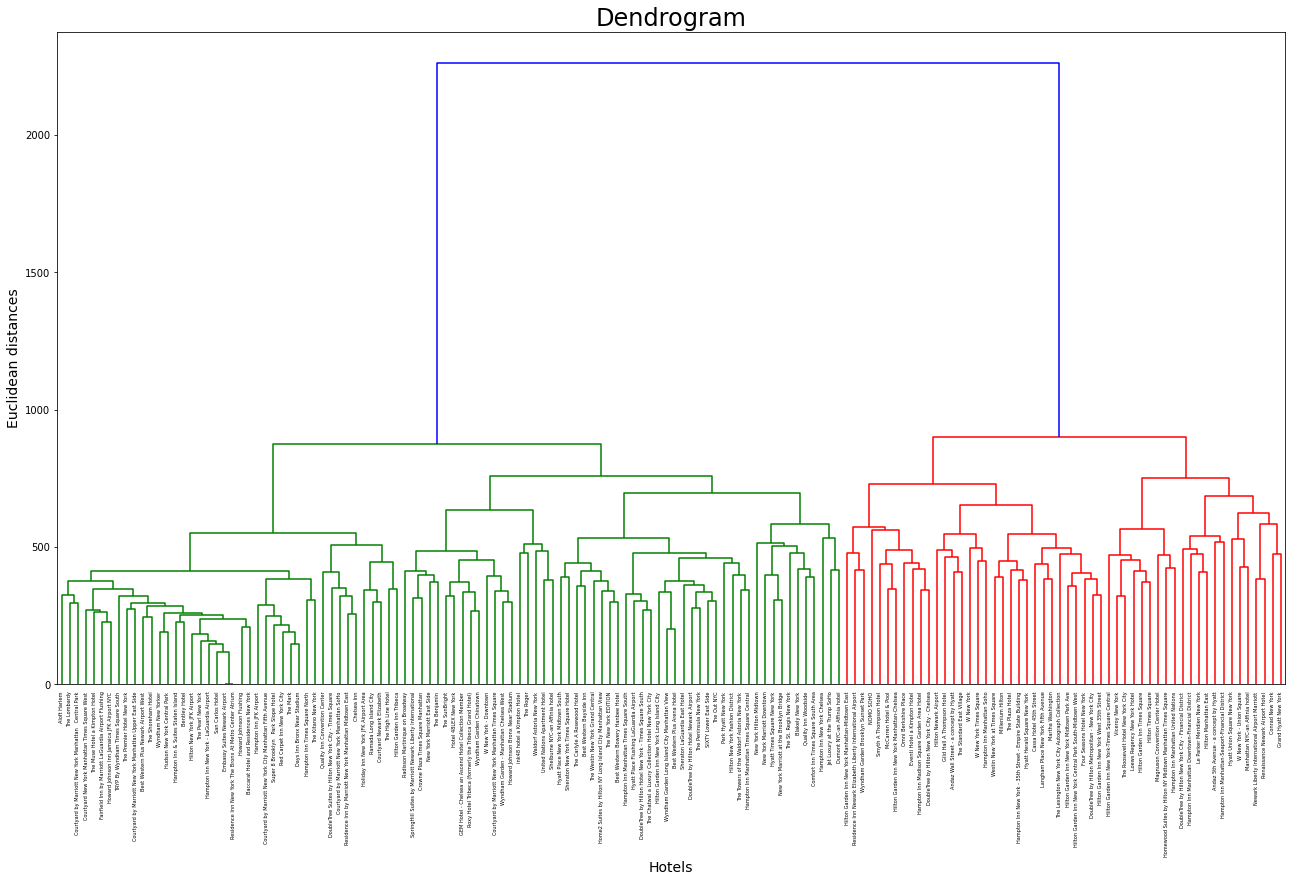

In [30]:
#Converting dataframe to array
X = selected_data_norm.iloc[:, :].values
#Plotting the Dendogram
plt.figure(figsize=(22,12))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'), labels=selected_data_norm.index)
plt.title('Dendrogram',fontsize=24)
plt.xlabel('Hotels',fontsize=14)
plt.ylabel('Euclidean distances',fontsize=14)

plt.show()